<a href="https://colab.research.google.com/github/vishesh711/kaggle_competition_Poisonous_Mushrooms_RandomForest/blob/main/kaggle_competition_Poisonous_Mushrooms_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [32]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [33]:
!kaggle competitions download -c playground-series-s4e8

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [34]:
train=pd.read_csv("/content/train.csv", index_col=0)
test=pd.read_csv("/content/test.csv", index_col=0)

In [35]:
print(f'Training Set\nRows: {train.shape[0]} | Cols: {train.shape[1]}\n')

print(f'Testing Set\nRows: {test.shape[0]} | Cols: {test.shape[1]}')

Training Set
Rows: 3116945 | Cols: 21

Testing Set
Rows: 2077964 | Cols: 20


In [36]:
train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [37]:
test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 523.2+ MB


In [39]:
train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3116941.0,6.31,4.66,0.03,3.32,5.75,8.24,80.67
stem-height,3116945.0,6.35,2.70,0.00,4.67,5.88,7.41,88.72
stem-width,3116945.0,11.15,8.10,0.00,4.97,9.65,15.63,102.90


In [40]:
# Check for missing values
train_na = (train.isna()
                    .sum()
                    .reset_index()
                    .sort_values(0, ascending=False)
                ).rename(columns={'index':'col',0:'na'})

train_na['percentage_na'] = (train_na['na'] / len(train)).round(2)

train_na.style.background_gradient()

,col,na,percentage_na
14,veil-type,2957493,0.950000
18,spore-print-color,2849682,0.910000
11,stem-root,2757023,0.880000
15,veil-color,2740947,0.880000
12,stem-surface,1980861,0.640000
7,gill-spacing,1258435,0.400000
3,cap-surface,671023,0.220000
6,gill-attachment,523936,0.170000
17,ring-type,128880,0.040000
8,gill-color,57,0.000000


In [41]:
train[train.duplicated()]

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,


In [42]:
cols_drop = ['veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface']

In [43]:
train.drop(columns=cols_drop, inplace=True)
test.drop(columns=cols_drop, inplace=True)

In [44]:
categorical_var = train.select_dtypes('object').columns
continous_var = train.select_dtypes('float').columns

In [45]:
# Check labels
pd.set_option('display.max_rows', None)

for col in train[categorical_var].columns:
    print(train[col].value_counts())

pd.set_option('display.max_rows', 5)

class
p    1705396
e    1411549
Name: count, dtype: int64
cap-shape
x            1436026
f             676238
s             365146
b             318646
o             108835
p             106967
c             104520
d                 65
e                 60
n                 41
w                 36
t                 36
g                 34
y                 33
r                 32
a                 30
u                 27
z                 22
l                 21
i                 14
k                 13
h                  6
7 x                2
3.55               2
m                  2
4.97               2
8                  2
6.44               1
8.3                1
7.6                1
17.44              1
4.33               1
2.82               1
3.91               1
6.21               1
8.29               1
54.78              1
20.25              1
3.52               1
3.04               1
ring-type          1
10.13              1
is p               1
7.43               1
0.82    

In [46]:
# Create a list containing the alphabet letters
alhpabet = list(map(chr,range(97,123)))

In [47]:
# Fixing some values
train[categorical_var] = train[categorical_var].map(lambda x: 'Unkwnown' if x not in alhpabet else x)
test[categorical_var[1:]] = test[categorical_var[1:]].map(lambda x: 'Unkwnown' if x not in alhpabet else x)

In [48]:
train['count'] = 1

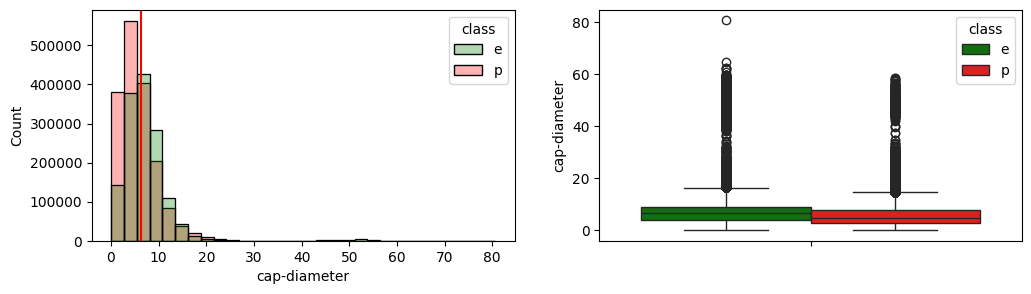

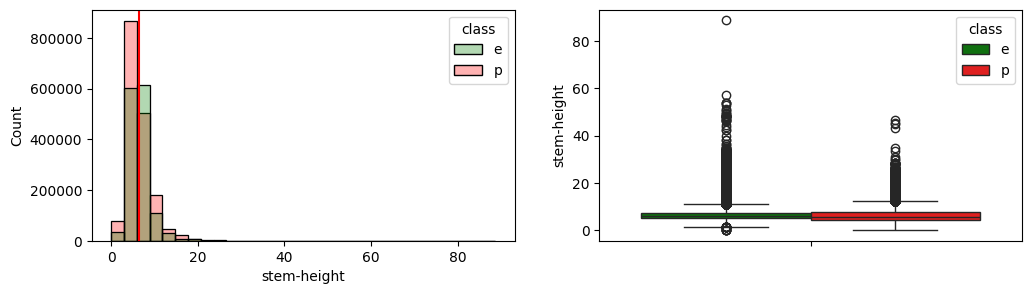

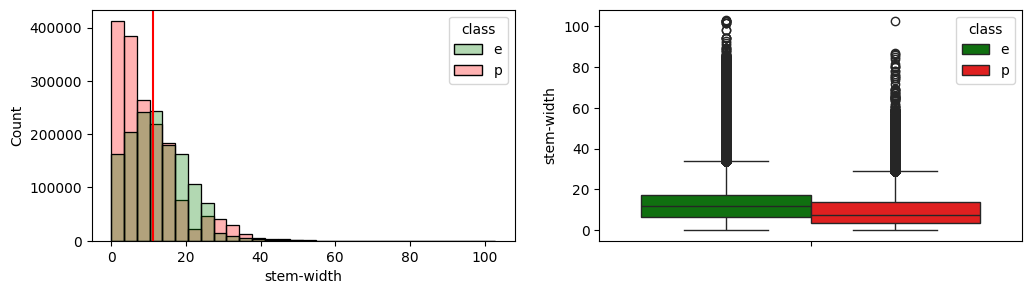

In [49]:
palette = ['green', 'red']

for num_var in continous_var:

    fig, ax = plt.subplots(1, 2, figsize=(12, 3))

    # Histograms
    sns.histplot(data=train,
                      x=num_var,
                      bins = 30,
                      hue = 'class',
                      palette=palette,
                      #kde=True,
                      alpha=0.3,
                      ax=ax[0]
                )
    # Mean vertical line
    ax[0].axvline(np.mean(train[num_var]), color="red")

    # Boxplots
    sns.boxplot(data=train,
                     y=num_var,
                     hue = 'class',
                     palette=palette,
                     #showfliers=False,
                     ax=ax[1]
                   );

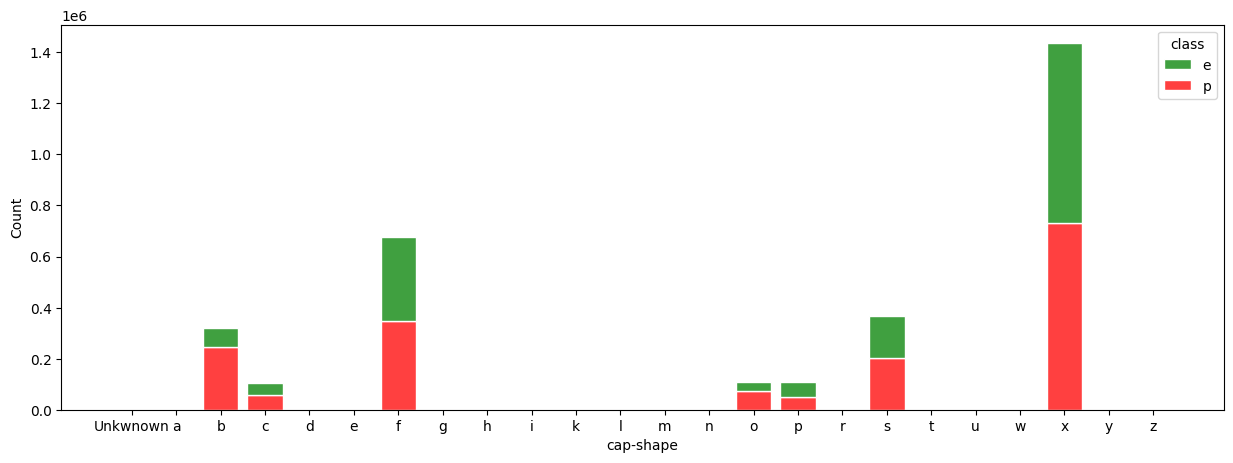

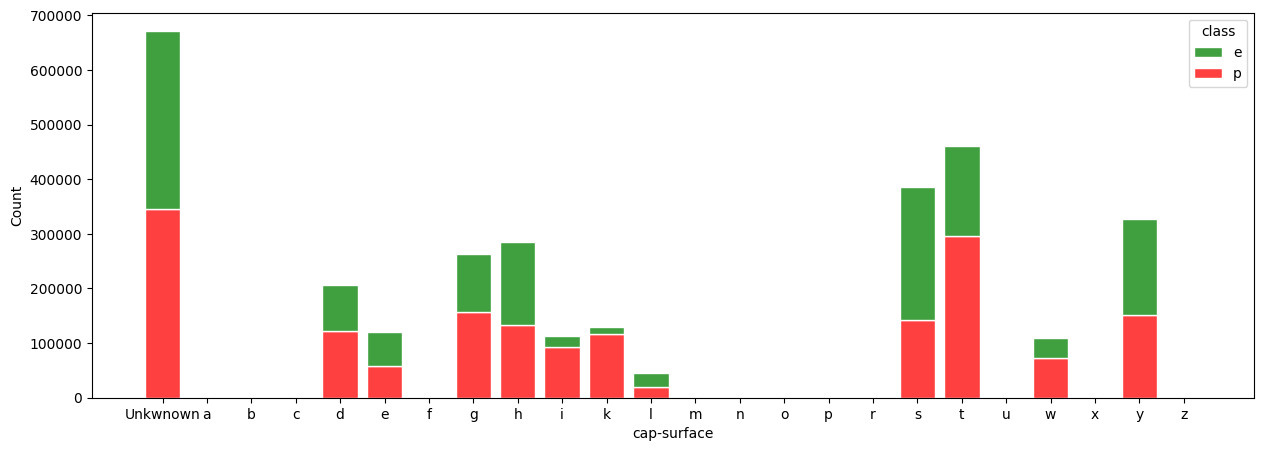

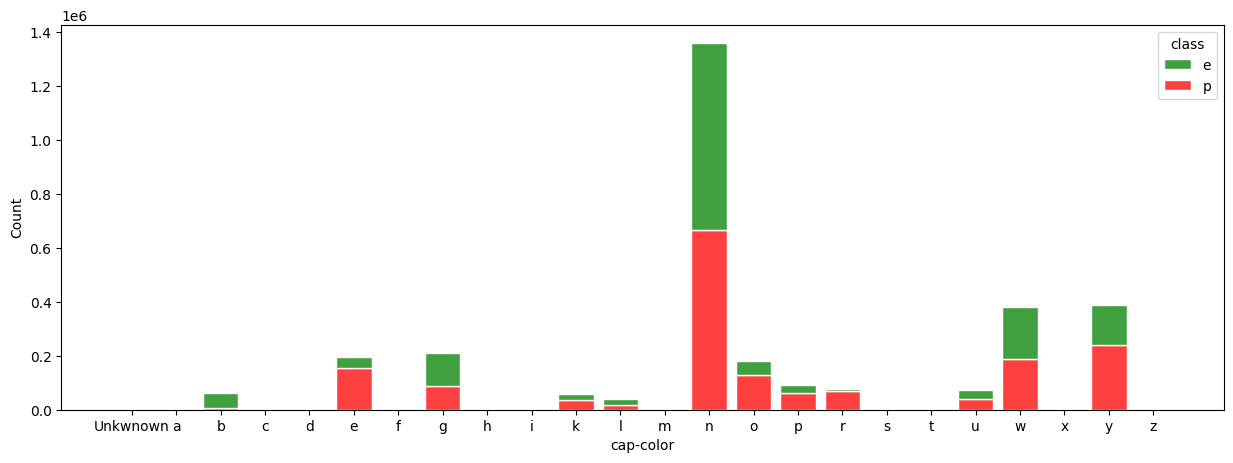

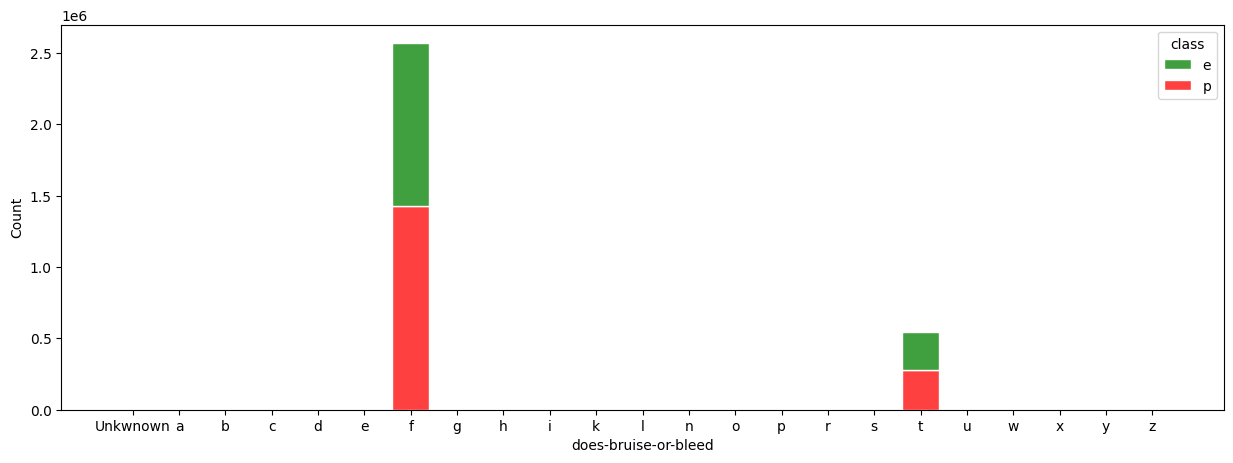

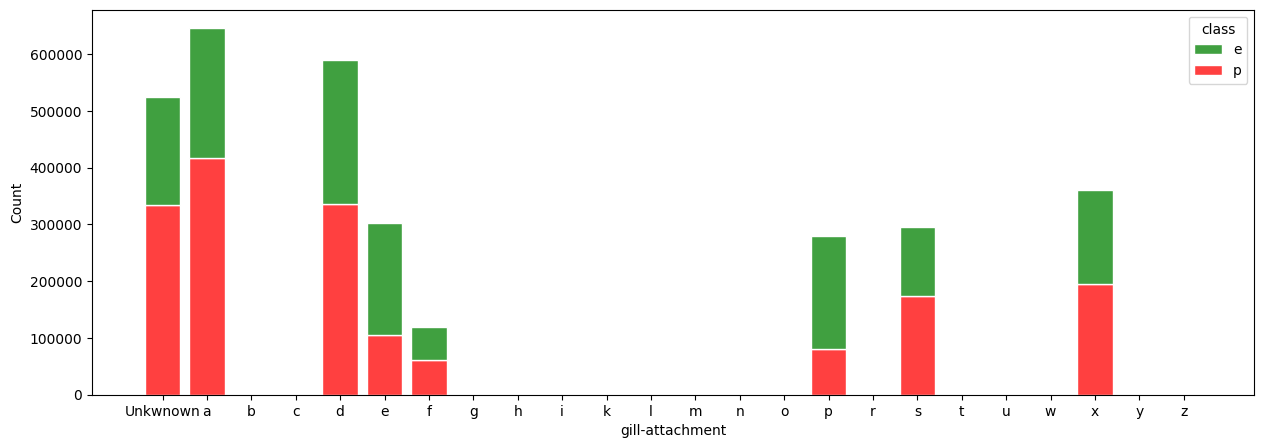

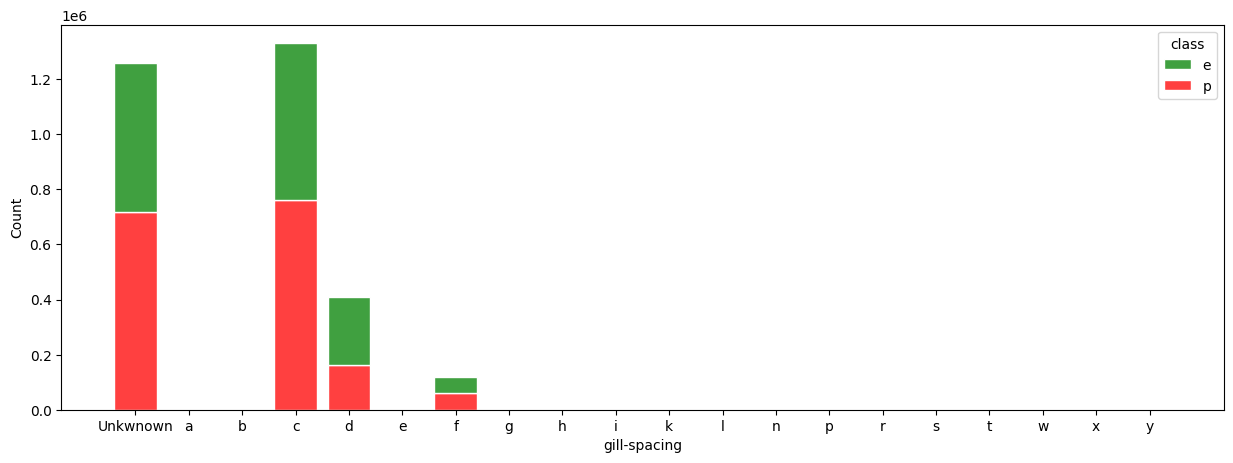

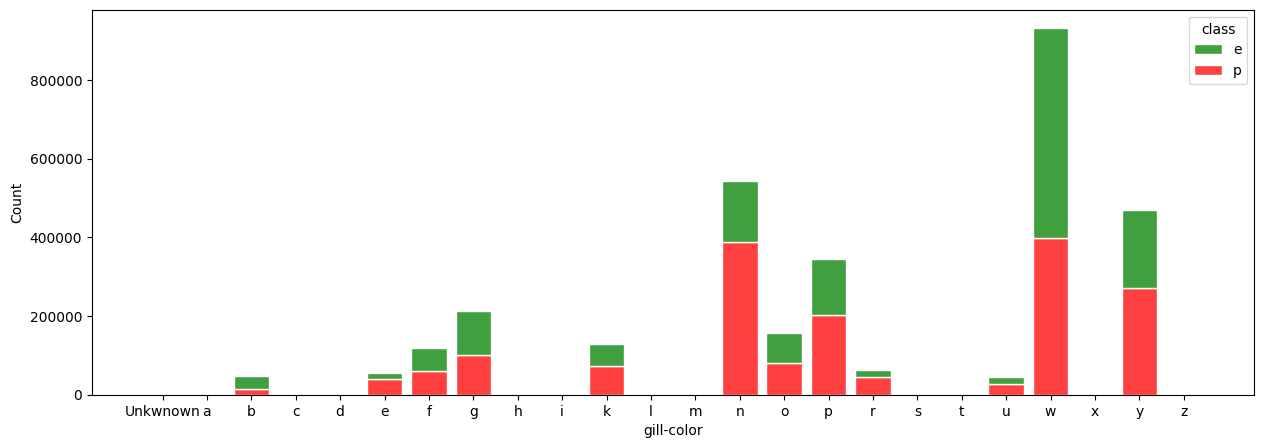

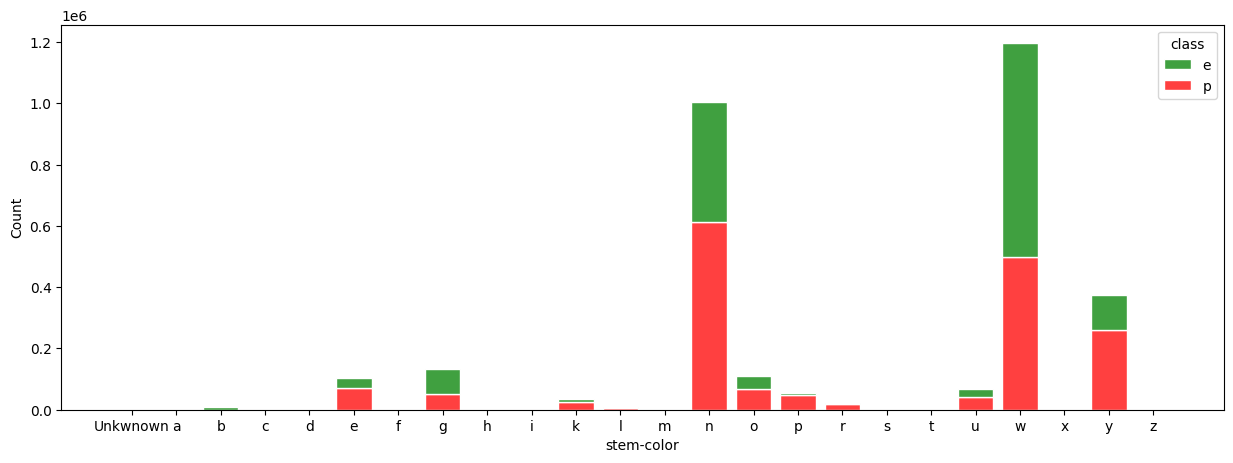

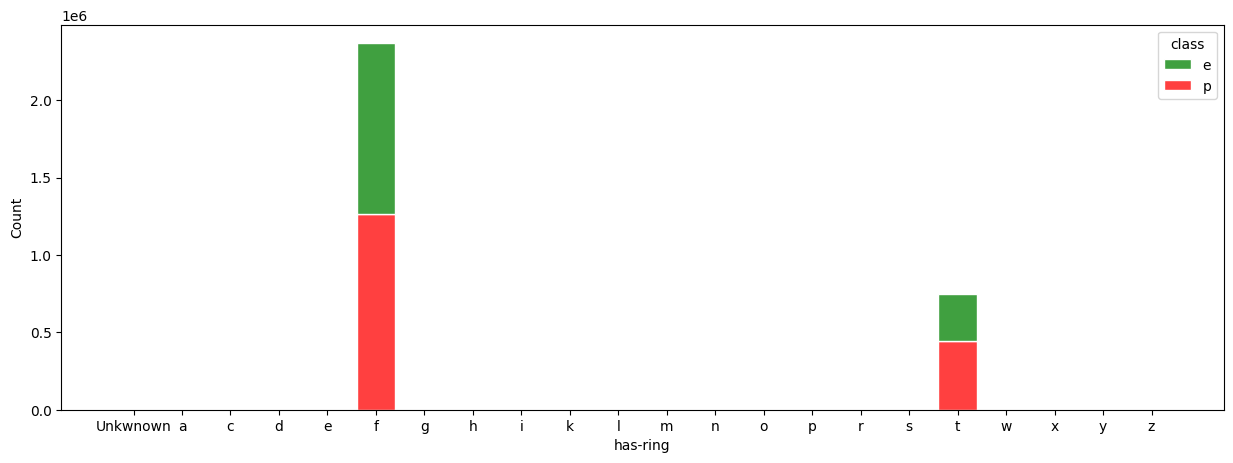

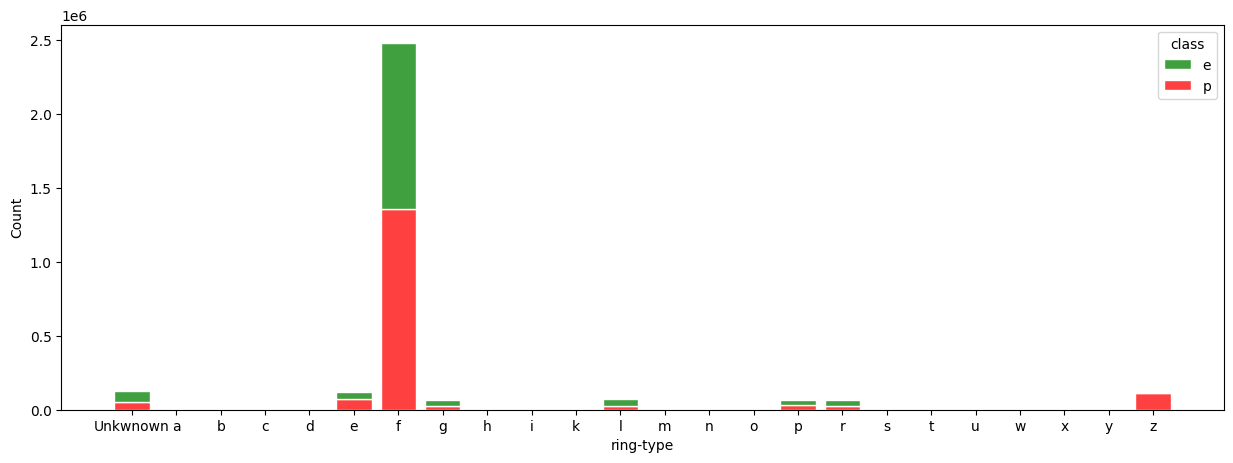

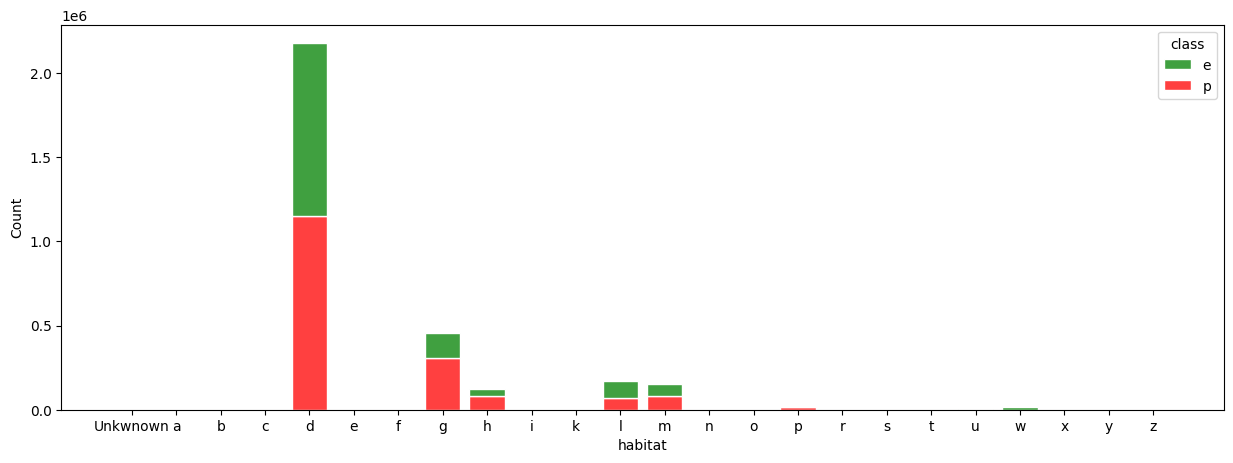

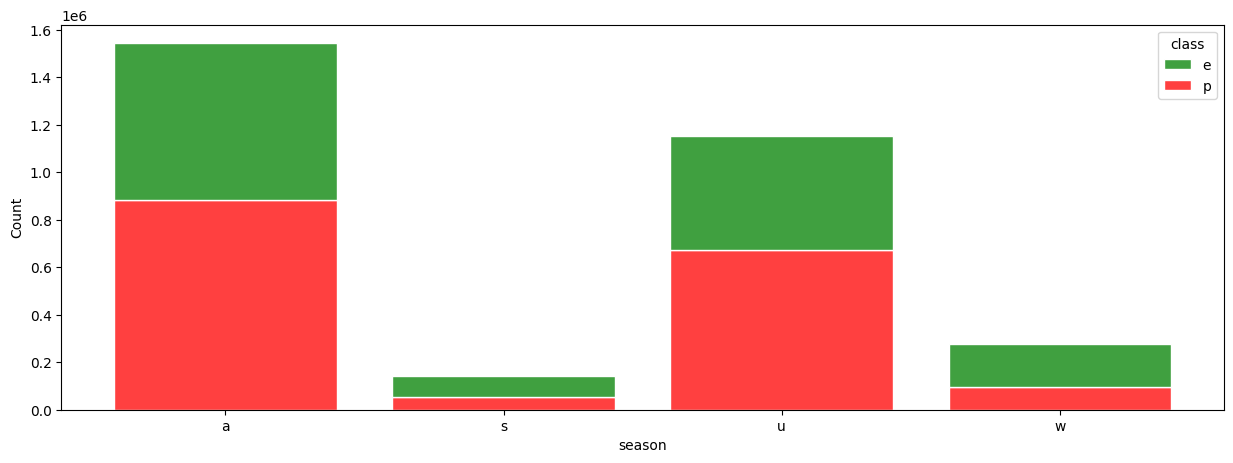

In [50]:
for col in train[categorical_var].columns:
    if col != 'class':
        plt.figure(figsize=(15,5,))
        sns.histplot(data=train[[col,'class','count']].groupby([col,'class']).sum().reset_index(),
                        x=col,
                        weights='count',
                        hue='class',
                        multiple='stack',
                        palette=palette,
                        edgecolor='white',
                        shrink=0.8
                    );

In [51]:
# Replace missing continous var with the respective mean value
train['cap-diameter'] = train['cap-diameter'].replace(np.nan,train['cap-diameter'].mean())
train['stem-height'] = train['stem-height'].replace(np.nan,train['stem-height'].mean())

test['cap-diameter'] = test['cap-diameter'].replace(np.nan,test['cap-diameter'].mean())
test['stem-height'] = test['stem-height'].replace(np.nan,test['stem-height'].mean())

In [52]:
# Encode the categorical variables
enc = LabelEncoder()

for var in categorical_var:
    train[var] = enc.fit_transform(train[var])


for var in categorical_var[1:]:
    test[var] = enc.fit_transform(test[var])

In [53]:
# Crate independent and dependent varaibles
X = train.drop(columns=['count','class'])
y = train['class']

In [54]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [55]:
rf = RandomForestClassifier(random_state=0)

In [56]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [57]:
y_pred = rf.predict(X_test)

In [58]:
matthews_corrcoef(y_test, y_pred)

0.9827131941043411

SUB


In [59]:
y_pred = rf.predict(test)

In [60]:
test_predictions = np.where(y_pred == 0, 'e', 'p')

In [61]:
submission_df = pd.DataFrame({'id': test.index,
                              'Target':test_predictions})

In [62]:
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,id,Target
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
